<a href="https://colab.research.google.com/github/gubbriaco/FPGA-VHDL-Wallace-multiplier/blob/main/potholes_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potholes Detection using Convolutional Neural Networks (CNNs)
## Overview
This notebook explores the application of Convolutional Neural Networks (CNNs) for pothole detection in road images. The model is developed and trained using Google Colab, a cloud-based Jupyter notebook environment, and leverages a dataset available in the Google Drive directory `/datasets/kaggle/pothole-detection-dataset/`.

## Dataset
The dataset used for this project is sourced from Kaggle and is accessible in the Google Drive folder mentioned above. It includes a collection of images annotated for pothole presence, serving as the training and testing data for the CNN model.

## Tools and Libraries
- Google Colab: A cloud-based platform for developing and running Jupyter notebooks.
- TensorFlow and Keras: Deep learning frameworks used for building and training the CNN model.
- Google Drive: Storage and access to the dataset.

## Notebook Structure
1. Loading and Preprocessing the Dataset
2. Model Architecture
3. Training the CNN Model
4. Evaluation and Testing
5. Results and Analysis

## Setup
To run this notebook, ensure that you have access to Google Colab and the necessary permissions to link to the dataset stored in the specified Google Drive path.

### Dataset Link
[Google Drive - Pothole Detection Dataset](https://drive.google.com/drive/folders/your_dataset_folder_path)

In [50]:
!pip install tensorflow

In [51]:
!nvidia-smi

Fri Jan 19 23:43:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [52]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras import layers,Sequential,Input

import tensorflow_hub as hub

In [53]:
# Define the paths to your dataset subfolders
data_directory = pathlib.Path('/content/drive/MyDrive/datasets/kaggle/pothole-detection-dataset/')
class_names = [item.name for item in data_directory.glob('*')][::-1]
print(f'class_names = {class_names}')

# Define the batch size
batch_size = 32

# Desidered image size
image_size_x = 224
image_size_y = 224


data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(
    data_directory,
    target_size = (image_size_x, image_size_y),
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'binary'
)
val_data = data_gen.flow_from_directory(
    data_directory,
    target_size = (image_size_x, image_size_y),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'binary'
)

class_names = ['normal', 'potholes']
Found 546 images belonging to 2 classes.
Found 135 images belonging to 2 classes.


In [54]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [55]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """

    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 10))

    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()
    plt.show()

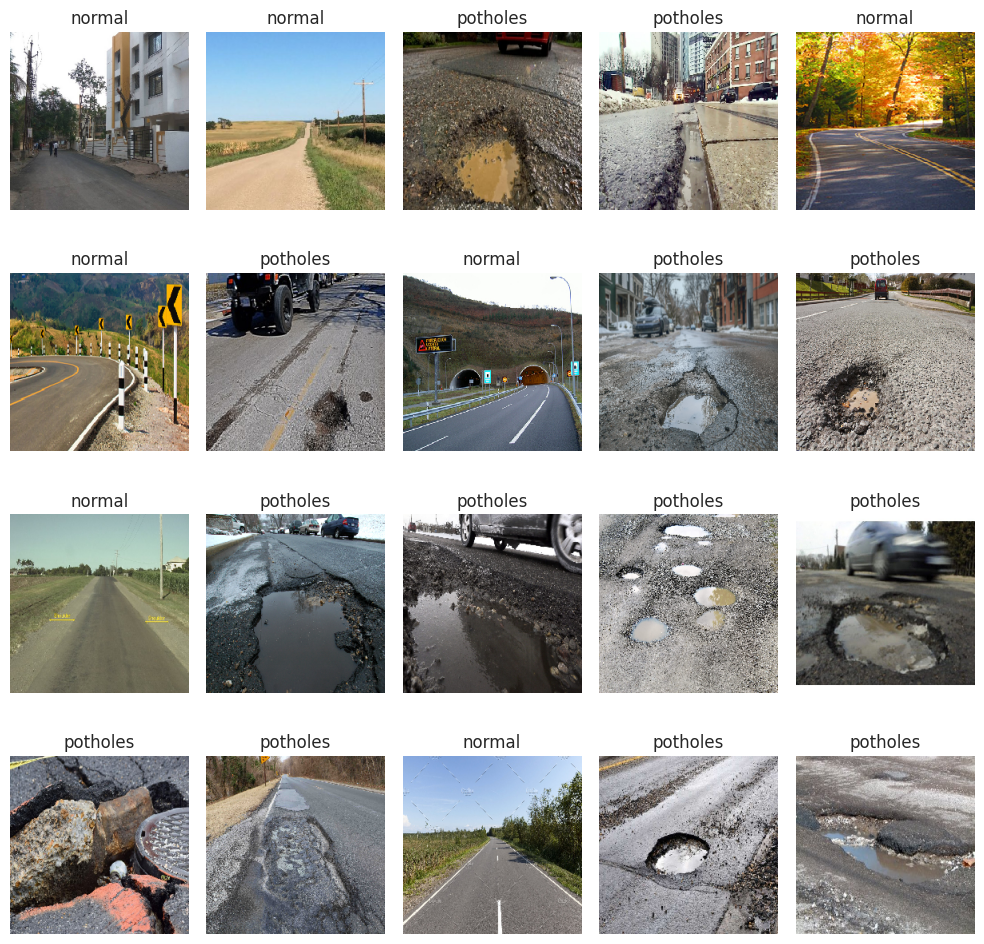

In [56]:
plot_random_images()

In [58]:
model = Sequential([
        Input(shape = images[0].shape),
        layers.Conv2D(34,(3,3),padding = "same",activation = "relu"),
        layers.MaxPooling2D((2,2),strides = 2),
        layers.Conv2D(64,(3,3),padding = "same",activation = "relu"),
        layers.MaxPooling2D((2,2),strides = 2),
        layers.Flatten(),
        layers.Dense(128,activation = "relu"),
        layers.Dense(2,activation = "softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 34)      952       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 34)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      19648     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [61]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [62]:
classifier = model.fit(
    train_data,
    batch_size = batch_size,
    epochs = 14,
    validation_data = val_data,
    verbose = 1,
    callbacks = [reduce_lr]
)

Epoch 1/14
18/18 [==============================] - 14s 819ms/step - loss: 0.2275 - accuracy: 0.9231 - val_loss: 0.3329 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 2/14
18/18 [==============================] - 12s 642ms/step - loss: 0.1814 - accuracy: 0.9267 - val_loss: 0.3299 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 3/14
18/18 [==============================] - 14s 764ms/step - loss: 0.1650 - accuracy: 0.9469 - val_loss: 0.3677 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 4/14
18/18 [==============================] - 12s 704ms/step - loss: 0.1318 - accuracy: 0.9524 - val_loss: 0.3671 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 5/14
18/18 [==============================] - 13s 735ms/step - loss: 0.0853 - accuracy: 0.9634 - val_loss: 0.3548 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 6/14
18/18 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9872
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 [==============================] - 12s 729ms

In [63]:
model.evaluate(val_data)

5/5 [==============================] - 3s 410ms/step - loss: 0.3917 - accuracy: 0.8667


[0.39166074991226196, 0.8666666746139526]

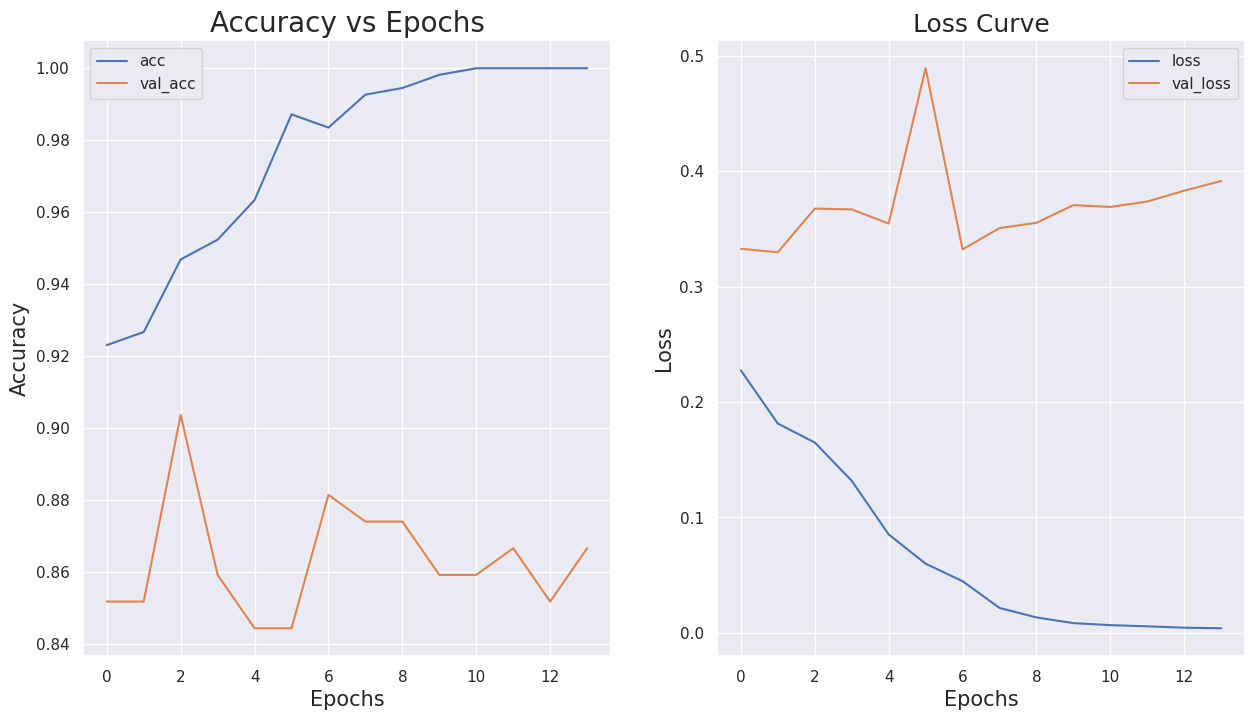

In [64]:
def model_performance_graphs():

    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()

model_performance_graphs()

In [71]:
model.save('/content/drive/MyDrive/models/kaggle/pothole-detection-dataset/model.h5')

In [72]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/models/kaggle/pothole-detection-dataset/model.h5')

In [76]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(image_size_x, image_size_y))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed

1/1 [==============================] - 0s 30ms/step
Predicted class: pothole


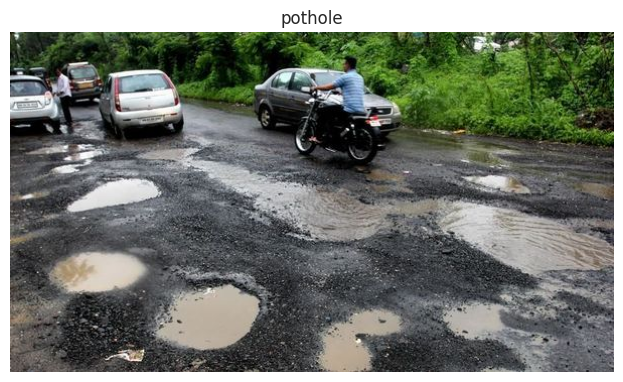

In [80]:
img_path = "/content/drive/MyDrive/datasets/kaggle/pothole-detection-dataset/potholes/10.jpg"
img = preprocess_images(img_path)
prediction = loaded_model.predict(img)

predicted_class_index = np.argmax(prediction)

class_labels = ['normal','pothole']
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

from PIL import Image
img = Image.open(img_path)
plt.imshow(img)
plt.title(predicted_class_label)
plt.axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 19ms/step
Predicted class: normal


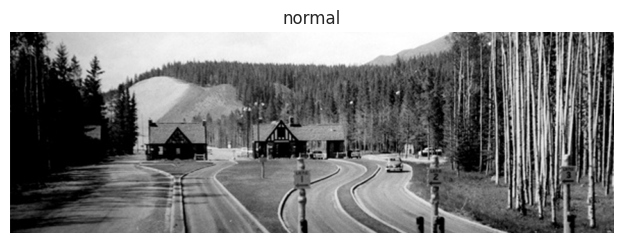

In [81]:
img_path = "/content/drive/MyDrive/datasets/kaggle/pothole-detection-dataset/normal/10.jpg"
img = preprocess_images(img_path)
prediction = loaded_model.predict(img)

predicted_class_index = np.argmax(prediction)

class_labels = ['normal','pothole']
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

from PIL import Image
img = Image.open(img_path)
plt.imshow(img)
plt.title(predicted_class_label)
plt.axis('off')
plt.tight_layout()
plt.show()